## AR Mock

### Questions
- Where exactly does learning and inference happen in PyMC3?
- What is the complexity of the model? -> Quantify variables and runtime exactly!
- What about the identifiability constraints?

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
columns = ['home_score', 'away_score', 'home_team', 'away_team', 'i_home', 'i_away']
data = [[2,1,'Arsenal','Liverpool',0,1],[0,2,'Liverpool','Arsenal',1,0],
        [1,1,'Burnley','Stoke City',2,3],[1,0,'Stoke City','Burnley',3,2]]

# data = [[2,1,'Arsenal','Liverpool',0,1],[0,2,'Liverpool','Arsenal',1,0]]

df = pd.DataFrame(data=data, columns=columns)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

print "num_teams: %d, num_games: %d" %(num_teams, num_games)

df

num_teams: 4, num_games: 4


,home_score,away_score,home_team,away_team,i_home,i_away
0,2,1,Arsenal,Liverpool,0,1
1,0,2,Liverpool,Arsenal,1,0
2,1,1,Burnley,Stoke City,2,3
3,1,0,Stoke City,Burnley,3,2


In [33]:
with pm.Model() as model:
    # global home and intercept params?
    home = pm.Normal('home', 0, .001)
    intercept = pm.Normal('intercept', 0, .001)
    tau_att =  pm.Exponential('tau_att', 1)
    tau_def =  pm.Exponential('tau_def', 1)

    atts = pm.GaussianRandomWalk('atts', tau_att**-2, shape=[num_teams, num_games])
    defs = pm.GaussianRandomWalk('defs', tau_def**-2, shape=[num_teams, num_games])
    
    home_theta  = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


In [34]:
with model:
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start)

ValueError: Optimization error: max, logp or dlogp at max have non-finite values. Some values may be outside of distribution support. max: {'defs': array([[  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00]]), 'intercept': array(-5.218572550077921), 'atts': array([[  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00],
       [  5.09406847e+00,   3.05948219e-03,   3.05948219e-03,
         -6.40483250e+00]]), 'home': array(-2.1037639630128853), 'tau_att_log': array(-306.46601255711954), 'tau_def_log': array(-306.46601255711954)} logp: array(27929.58481543997) dlogp: array([ -54.25563543, -614.15274932,           nan,           nan,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998,
       -158.52726604,    1.99388704,    1.99388704,    0.99999998])Check that 1) you don't have hierarchical parameters, these will lead to points with infinite density. 2) your distribution logp's are properly specified. Specific issues: 
defs.dlogp bad at idx: (array([16]),) with values: [ nan]
atts.dlogp bad at idx: (array([16]),) with values: [ nan]

In [19]:
trace.varnames

['home',
 'intercept',
 'tau_att_log',
 'tau_def_log',
 'atts',
 'defs',
 'tau_att',
 'tau_def']

array([[<matplotlib.axes.AxesSubplot object at 0x11f687710>,
        <matplotlib.axes.AxesSubplot object at 0x122480910>]], dtype=object)

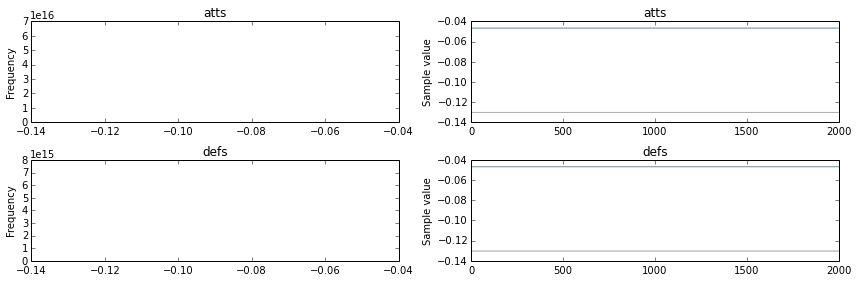

In [31]:
pm.traceplot(trace, ['atts', 'defs'])